**Задача** - провести анализ поведения пользователей на сайте Яндекс.Афиша и выделить выгодные источники трафика

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
costs = pd.read_csv('costs.csv')
orders = pd.read_csv('orders_log.csv')
visits = pd.read_csv('visits_log.csv')

Ознакомимся с данными

In [3]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [4]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Найдем количество уникальных пользователей в день

In [6]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['start_date'] = visits['start_ts'].dt.strftime('%Y-%m-%d')

<AxesSubplot:xlabel='start_date'>

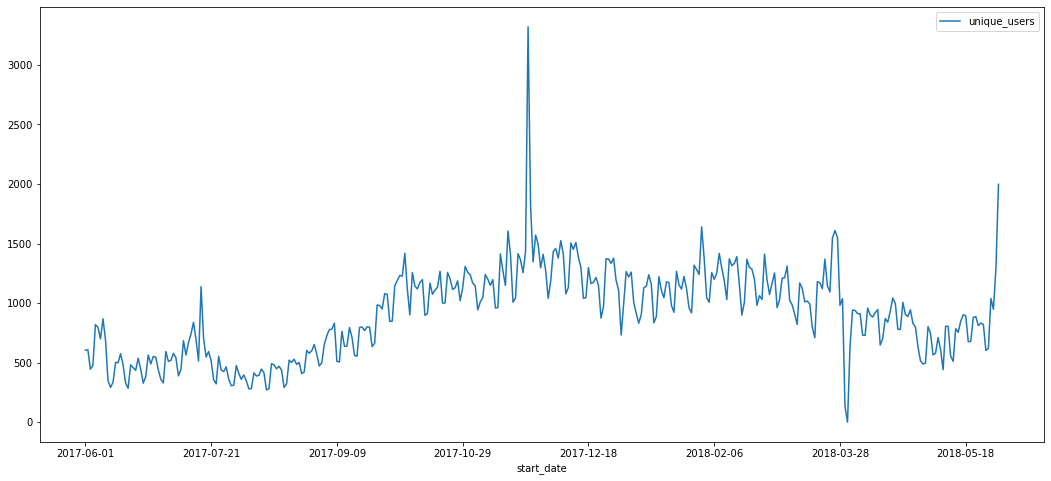

In [7]:
DAU = visits.groupby('start_date').agg({'uid': 'nunique'})
DAU.columns = ['unique_users']
DAU.plot(figsize=(18, 8))

In [8]:
DAU['unique_users'].mean()

907.9917582417582

Получился довольно занятный график распределения уникальных пользователей каждый день. На протяжении всего графика видны некритичные регулярные падения на 1-2 дня, которые затем сменяются на 4-6 дневные подъемы. То ли еженедельная работа на серверах, то ли афишу все проверяют в определенный день недели. Надо проверить. Также стоит отметить, что в целом за 1000 уникальных пользователей в день Афиша перевалила примерно с октября 2017 года и оставалась выше 1000 вплоть до апреля 2018 года. Очевидное объяснение этому то, что ближе к лету многие театры заканчивают свой сезон и начинают его снова с осени.

In [9]:
DAU = DAU.reset_index()
DAU['day_of_week'] = pd.to_datetime(DAU['start_date']).dt.dayofweek
day_of_week_diff = DAU.pivot_table(index='day_of_week', values='unique_users', aggfunc='mean')
day_of_week_diff

,unique_users
day_of_week,
0,995.115385
1,960.153846
2,934.057692
3,1012.490566
4,957.615385
5,744.903846
6,746.490196


Видна тенденция, что на выходных гораздо меньше заходят в Яндекс.Афишу, чем в течение рабочей недели. Могу предположить, что это связано с тем, что большинство людей покупают билеты непосредственно перед событием (в день показа/за день или два). Потому что порой тяжело бывает предсказать расписание будущей рабочей недели, пока ты в нее не окунешься.

In [10]:
visits

,device,end_ts,source_id,start_ts,uid,start_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27
...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02


Теперь найдем кол-во уникальных пользователей в каждую неделю и построим график

In [11]:
visits['first_day'] = visits['start_date'].min()
visits['week'] = pd.to_datetime(visits['start_date']) - pd.to_datetime(visits['first_day'])
visits['week'] = visits['week'] / np.timedelta64(1, 'W')
visits['week'] = visits['week'].round().astype('int')
visits

,device,end_ts,source_id,start_ts,uid,start_date,first_day,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-06-01,29
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2017-06-01,38
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-01,4
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2017-06-01,50
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-06-01,30
...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-06-01,8
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2017-06-01,34
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2017-06-01,39
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-06-01,22


<AxesSubplot:xlabel='week'>

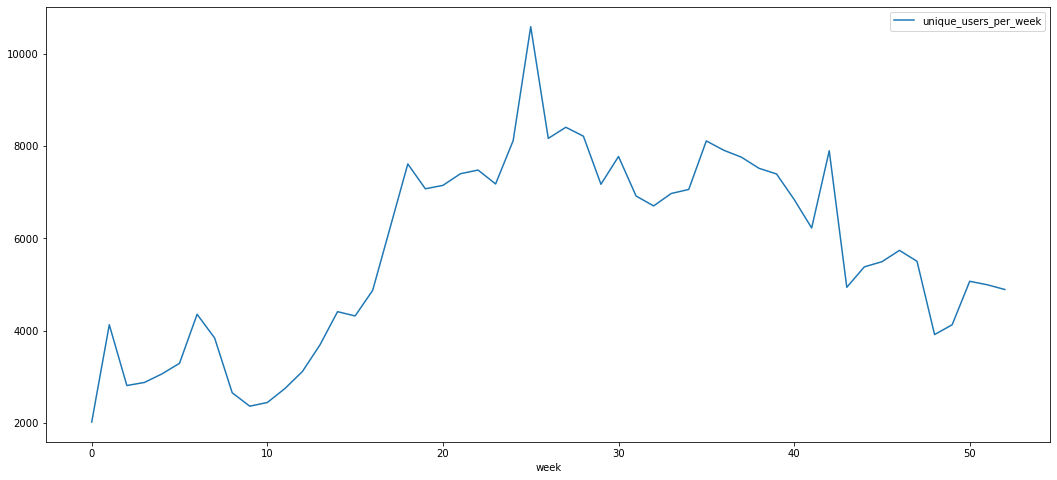

In [12]:
WAU = visits.groupby('week').agg({'uid': 'nunique'})
WAU.columns = ['unique_users_per_week']
WAU.plot(figsize=(18, 8))

In [13]:
WAU['unique_users_per_week'].mean()

5716.245283018868

На графике видна ярко выраженная 'горка' на 25 неделе - посетителей более 10тыс. человек при общем среднем показателе за весь период в 5716 человек. 

И наконец кол-во уникальных пользователей на каждый месяц

<AxesSubplot:xlabel='month_start'>

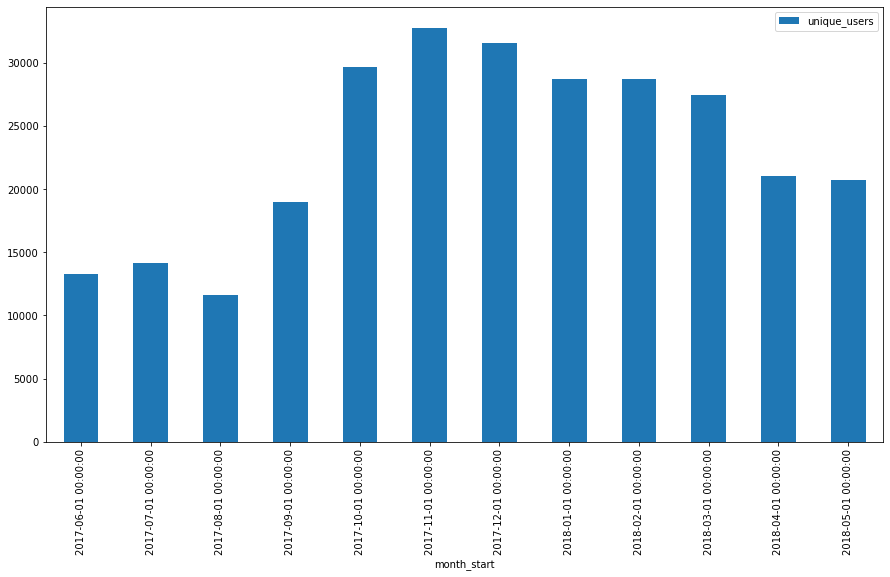

In [14]:
visits['month_start'] = visits['start_date'].astype('datetime64[M]')
MAU = visits.groupby('month_start').agg({'uid': 'nunique'})
MAU.columns = ['unique_users']
MAU.plot(figsize=(15, 8), kind='bar')

In [15]:
MAU.head(12)

,unique_users
month_start,
2017-06-01,13259
2017-07-01,14183
2017-08-01,11631
2017-09-01,18975
2017-10-01,29692
2017-11-01,32797
2017-12-01,31557
2018-01-01,28716
2018-02-01,28749


Как видно, с наступлением сентября посетителей стало гораздо больше, что неудивительно - начало нового театрального сезона. Другой момент в том, что с апреля кол-во резко упало, хотя сезон обычно заканчивается в конце мая.

Найдем сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени

In [16]:
mean_daily_users = visits.groupby(['start_date', 'uid']).agg({'uid': 'count'})
mean_daily_users.columns = ['entries']
mean_daily_users.reset_index(inplace=True)
mean_daily_users = mean_daily_users.groupby('start_date').agg({'entries': 'mean'})
mean_daily_users.head(10)

,entries
start_date,
2017-06-01,1.097521
2017-06-02,1.082237
2017-06-03,1.071910
2017-06-04,1.071429
2017-06-05,1.089024
2017-06-06,1.097867
2017-06-07,1.127325
2017-06-08,1.081797
2017-06-09,1.086331


<AxesSubplot:xlabel='start_date'>

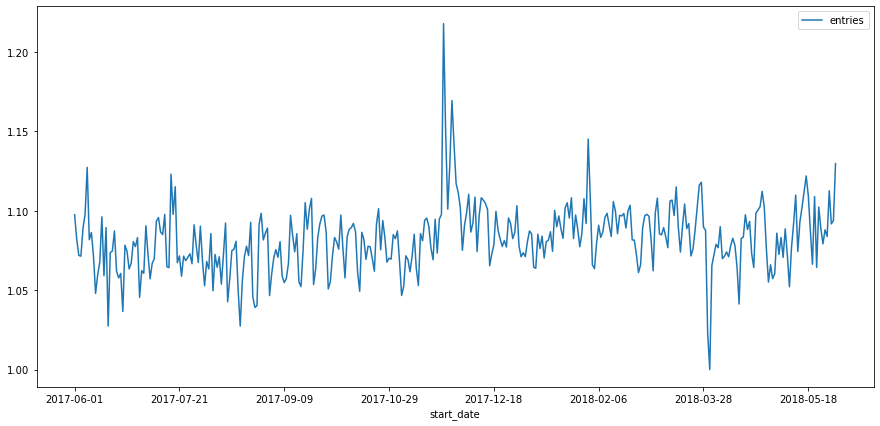

In [17]:
mean_daily_users.plot(figsize=(15, 7))

Как видим, абсолютному большинству хватает один раз в день зайти на сайт, чтобы проверить расписание или сразу купить билеты. И в среднем едва ли каждому десятому посетителю нужно еще раз зайти на сайт. 

Теперь посмотрим сколько времени пользователи проводят на сайте, построив график распределения.

In [18]:
visits['using_time_minutes'] = pd.to_datetime(visits['end_ts']) - pd.to_datetime(visits['start_ts'])
visits

,device,end_ts,source_id,start_ts,uid,start_date,first_day,week,month_start,using_time_minutes
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-06-01,29,2017-12-01,0 days 00:18:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2017-06-01,38,2018-02-01,0 days 00:28:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-01,4,2017-07-01,0 days 00:00:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2017-06-01,50,2018-05-01,0 days 00:24:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-06-01,30,2017-12-01,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-06-01,8,2017-07-01,0 days 00:00:19
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2017-06-01,34,2018-01-01,0 days 00:00:19
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2017-06-01,39,2018-03-01,0 days 00:00:19
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-06-01,22,2017-11-01,0 days 00:00:19


In [19]:
visits['using_time_minutes'] = visits['using_time_minutes'] / np.timedelta64(1, 'm')
visits['using_time_minutes'] = visits['using_time_minutes'].round().astype('int')
visits

,device,end_ts,source_id,start_ts,uid,start_date,first_day,week,month_start,using_time_minutes
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-06-01,29,2017-12-01,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2017-06-01,38,2018-02-01,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-01,4,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2017-06-01,50,2018-05-01,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-06-01,30,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-06-01,8,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2017-06-01,34,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2017-06-01,39,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-06-01,22,2017-11-01,0


<AxesSubplot:xlabel='using_time_minutes', ylabel='Density'>

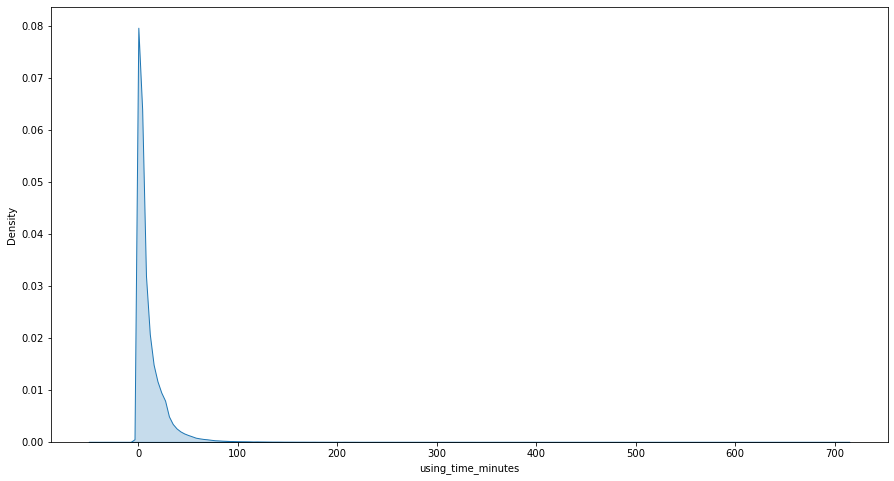

In [20]:
plt.figure(figsize=(15,8))
sns.kdeplot(visits['using_time_minutes'], shade=True)

<AxesSubplot:ylabel='Frequency'>

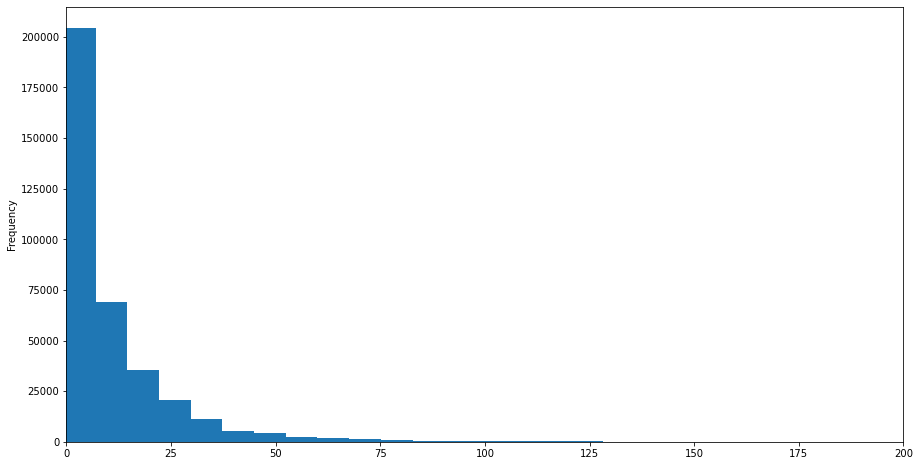

In [21]:
visits['using_time_minutes'].plot(kind='hist', bins=100, figsize=(15,8), xlim=(0,200))

По графикам видно, что посетители проводят на сайте не более 7 минут, но также есть случаи, когда проводят и дольше и в сумме люди, сидящие на сайте с 7 минут до часа почти сопоставимо с количеством людей, проводящих время менее 7 минут. 

Рассчитаем Retention Rate (коэффициент удержания) по посещениям на сайт

В первую очередь выделим самый первый месяц посещения пользователя на сайт

In [22]:
first_month_start = visits.groupby(['uid'])['month_start'].min()
first_month_start.name = 'first_month_start'
visits = visits.join(first_month_start, on='uid')
visits

,device,end_ts,source_id,start_ts,uid,start_date,first_day,week,month_start,using_time_minutes,first_month_start
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-06-01,29,2017-12-01,18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2017-06-01,38,2018-02-01,28,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-01,4,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2017-06-01,50,2018-05-01,24,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-06-01,30,2017-12-01,0,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-06-01,8,2017-07-01,0,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2017-06-01,34,2018-01-01,0,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2017-06-01,39,2018-03-01,0,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-06-01,22,2017-11-01,0,2017-11-01


Выделим месяц жизни когорты на каждый момент посещения

In [23]:
visits['cohort_lifetime'] = visits['month_start'] - visits['first_month_start']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

В отдельный датафрейм посчитаем кол-во уникальных пользователей на каждую когорту и на каждый месяц жизни

In [24]:
cohorts_visits = visits.groupby(
    ['first_month_start', 'cohort_lifetime']
).agg({'uid': 'nunique'}).reset_index()

Отдельно укажем кол-во уникальных пользователей на первый месяц жизни для удобства счета метрики удержания

In [25]:
initial_visits_count = cohorts_visits[cohorts_visits['cohort_lifetime'] == 0][['first_month_start', 'uid']]
initial_visits_count = initial_visits_count.rename(columns={'uid': 'cohort_users'})

Объединяем два датафрейма

In [26]:
cohorts_visits = cohorts_visits.merge(initial_visits_count, on='first_month_start')

Считаем коэффициент удержания

In [27]:
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']

In [28]:
retention_pivot = cohorts_visits.pivot_table(index='first_month_start', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month_start,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В целом мы наблюдаем картину, что большинство не возвращаются на сайт. Учитывая, что это Яндекс.Афиша, то стоит понимать, что многие не ходят по культурным мероприятиям постоянно. Некоторые из них интересуются определенными артистами, поэтому остальные мероприятия их зачастую не интересуют. 

Давайте все равно проверим, какой средний коэф. удержания на второй месяц жизни когорты

In [29]:
retention_pivot.mean(axis=0)[1]

0.06516659710392834

Округленно каждый 20-ый пользователь, посетивший сайт в первые месяц, возвращается на сайт во второй месяц

Теперь исследуем, сколько в среднем уходит времени каждым пользователем с первого захода на сайт до покупки

Выделим столбцы с юидом пользователя, его самым первым заходом на сайт и первой покупкой на сайте

In [30]:
visits_orders = visits.merge(orders, on='uid')
visits_orders = visits_orders[['uid', 'start_ts', 'buy_ts']]
visits_orders = visits_orders.groupby('uid').agg({'start_ts': 'min', 'buy_ts': 'min'})
visits_orders.drop_duplicates(inplace=True)
visits_orders

,start_ts,buy_ts
uid,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00


Считаем среднее значение

In [31]:
visits_orders['time_to_buy'] = pd.to_datetime(visits_orders['buy_ts']) - pd.to_datetime(visits_orders['start_ts'])
visits_orders['time_to_buy'].mean()

Timedelta('16 days 22:22:13.581459133')

Считаем медиану

In [32]:
visits_orders['time_to_buy'].median()

Timedelta('0 days 00:16:00')

Судя по среднему и медиане, можно констатировать факты, что 1) посетить сайт могут чисто из любопытства, а потом условно через пару месяцев купить билет на нужный концерт. Поэтому среднее значение такое огромное. 2) Но все-таки медиана здесь более объективный показатель, так как позволяет понять, что, если человеку нужен билет на определенное мероприятие, то проводит на сайте около 16 минут. Много это или мало? Человек просто просматривает варианты, обговаривает с друзьями, а потом только платит или все-таки есть какие-то проблемы на сайте, не позволяющие быстро оплатить? 

Рассчитаем среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев.

In [33]:
first_months_orders = orders.groupby(['uid']).agg({'buy_ts': 'min'})
first_months_orders.columns = ['first_buy_date']
orders = orders.join(first_months_orders, on='uid')

Выделяем отдельный датафрейм с полугодовым отрезком

In [34]:
orders['border_time'] = pd.to_timedelta('183 days')
orders['first_buy_date'] = orders['first_buy_date'].astype('datetime64')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
half_year_orders = orders[(orders['buy_ts'] - orders['first_buy_date']) < orders['border_time']]
half_year_orders
#orders['duration'] = orders['buy_ts'] - orders['first_buy_date']
#orders.info()
#half_year_orders = orders.query('buy_ts - first_buy_date < border_time')
#half_year_orders

,buy_ts,revenue,uid,first_buy_date,border_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,183 days
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,183 days
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,183 days
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,183 days
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,183 days
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,183 days
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,183 days
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,183 days
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,183 days


Считаем средний результат

In [35]:
six_months_orders = half_year_orders.groupby('uid').agg({'uid': 'count'})
six_months_orders.mean()

uid    1.333023
dtype: float64

Смотрим какие вообще имеются значения

In [36]:
six_months_orders['uid'].value_counts()

1      30528
2       4277
3       1006
4        329
5        132
6         64
7         30
8         22
10        15
13        11
11        10
12         9
9          7
16         6
15         5
21         5
18         5
17         4
14         4
19         3
25         3
20         3
23         3
22         3
29         3
45         2
54         2
42         2
38         2
34         2
24         2
26         1
90         1
121        1
27         1
61         1
88         1
30         1
62         1
58         1
160        1
117        1
85         1
147        1
115        1
48         1
46         1
106        1
40         1
37         1
132        1
35         1
97         1
33         1
127        1
Name: uid, dtype: int64

Подтверждается теория о том, что большинство посетителей, заходя один раз на сайт, сразу покупают билет на нужное мероприятие и могут не ходить на мероприятия полгода (и, соответственно, не заходить на сайт). Имеются, также интересные аномалии в виде покупок более 100 билетов за полгода, но тут могут быть учителя или организаторы групповых походов, покупающие билеты сразу на всю группу.

Высчитаем средний чек, применяя группировку по времени. Применим недельные отрезки

In [37]:
orders['first_week'] = orders['buy_ts'].min()
orders['week'] = (orders['buy_ts'] - orders['first_week']) / np.timedelta64(1, 'W')
orders['week'] = orders['week'].round().astype('int')
orders

,buy_ts,revenue,uid,first_buy_date,border_time,first_week,week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,183 days,2017-06-01 00:10:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,183 days,2017-06-01 00:10:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,183 days,2017-06-01 00:10:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,183 days,2017-06-01 00:10:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,183 days,2017-06-01 00:10:00,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,183 days,2017-06-01 00:10:00,52
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,183 days,2017-06-01 00:10:00,52
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,183 days,2017-06-01 00:10:00,52
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,183 days,2017-06-01 00:10:00,52


<AxesSubplot:xlabel='week'>

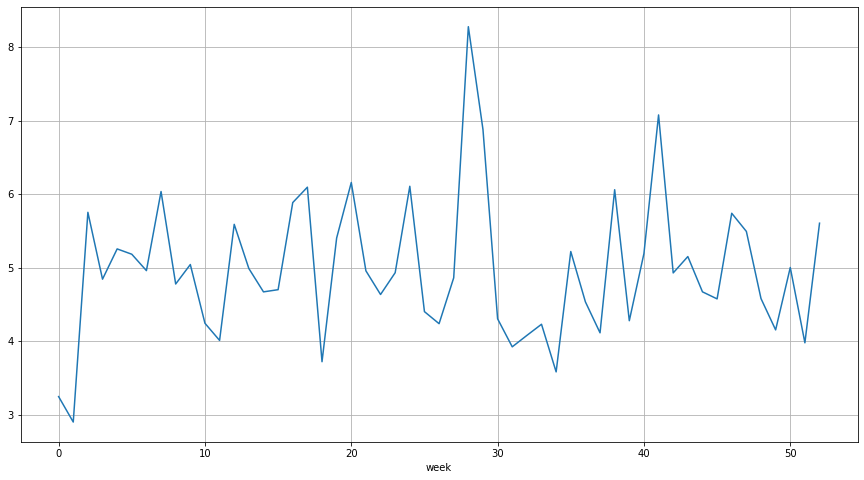

In [38]:
average_order_value = orders.groupby('week').agg({'revenue': ['count', 'sum']})
average_order_value.columns = ['quantity_orders', 'overall_sum_orders']
average_order_value['average_order_value'] = average_order_value['overall_sum_orders'] / average_order_value['quantity_orders']
average_order_value['average_order_value'].plot(figsize=(15, 8), grid=True)

In [39]:
average_order_value['average_order_value'].mean()

4.965942041395786

Средний чек за весь период достигает почти 5 условных единиц. Фиксируем недели, где средний чек был равен 4 или меньше. Недели: 11, 18, 31, 33, 51.

Теперь высчитаем LTV на покупателя по месячным когортам

In [40]:
orders

,buy_ts,revenue,uid,first_buy_date,border_time,first_week,week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,183 days,2017-06-01 00:10:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,183 days,2017-06-01 00:10:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,183 days,2017-06-01 00:10:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,183 days,2017-06-01 00:10:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,183 days,2017-06-01 00:10:00,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,183 days,2017-06-01 00:10:00,52
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,183 days,2017-06-01 00:10:00,52
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,183 days,2017-06-01 00:10:00,52
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,183 days,2017-06-01 00:10:00,52


Найдем дату первой покупки каждого покупателя

In [41]:
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders['first_order_month'] = first_orders['first_order_month'].astype('datetime64[M]')

Найдем кол-во новых покупателей на каждый первый месяц

In [42]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами

In [43]:
orders_new = pd.merge(orders, first_orders, on='uid')
del orders_new['first_week']
del orders_new['border_time']
orders_new['buy_ts'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new

,buy_ts,revenue,uid,first_buy_date,week,first_order_month
0,2017-06-01,17.00,10329302124590727494,2017-06-01 00:10:00,0,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01 00:25:00,0,2017-06-01
2,2017-06-01,0.37,17903680561304213844,2017-06-01 00:27:00,0,2017-06-01
3,2017-06-01,0.55,16109239769442553005,2017-06-01 00:29:00,0,2017-06-01
4,2017-06-01,0.37,14200605875248379450,2017-06-01 07:58:00,0,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-01,4.64,12296626599487328624,2018-05-31 23:50:00,52,2018-05-01
50411,2018-05-01,5.80,11369640365507475976,2018-05-31 23:50:00,52,2018-05-01
50412,2018-05-01,0.30,1786462140797698849,2018-05-31 23:54:00,52,2018-05-01
50413,2018-05-01,3.67,3993697860786194247,2018-05-31 23:56:00,52,2018-05-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [44]:
cohorts = orders_new.groupby(['first_order_month', 'buy_ts']).agg({'revenue': 'sum'}).reset_index()

In [45]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,buy_ts,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Так как маржинальность 100%, то нет нужды считать валовую прибыль для LTV - доход и будет равняться валовой прибыли. Считать LTV удобнее через возраст когорты, поэтому выделим возраст когорт

In [46]:
report['age'] = (report['buy_ts'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [47]:
report['ltv'] = report['revenue'] / report['n_buyers']
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.117586,0.52093,3.975792,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.084816,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,,,,,,,
2018-02-01,4.156987,0.278274,0.078515,0.074144,,,,,,,,


Посчитаем средний LTV на когорты, которые 'живут' не менее 6 месяцев

In [48]:
mean_ltv = output.loc[:pd.to_datetime('2017-11-01')].cumsum(axis=1)[6]
mean_ltv.mean()

8.387686429758398

Столько условных единиц прибыли принесли когорты, которые 'живут' не менее 6 месяцев за полгода. Теперь найдем сколько приносит каждая когорта за 6 месяцев.

In [49]:
cohort_2017_06_01 = output.loc[pd.to_datetime('2017-06-01')].cumsum()[6]
cohort_2017_07_01 = output.loc[pd.to_datetime('2017-07-01')].cumsum()[6]
cohort_2017_08_01 = output.loc[pd.to_datetime('2017-08-01')].cumsum()[6]
cohort_2017_09_01 = output.loc[pd.to_datetime('2017-09-01')].cumsum()[6]
cohort_2017_10_01 = output.loc[pd.to_datetime('2017-10-01')].cumsum()[6]
cohort_2017_11_01 = output.loc[pd.to_datetime('2017-11-01')].cumsum()[6]
print('Столько прибыли в среднем принесли когорты за полгода:')
print('Июньская когорта 2017 года: {:.2f}'.format(cohort_2017_06_01))
print('Июльская когорта 2017 года: {:.2f}'.format(cohort_2017_07_01))
print('Августовская когорта 2017 года: {:.2f}'.format(cohort_2017_08_01))
print('Сентябрьская когорта 2017 года: {:.2f}'.format(cohort_2017_09_01))
print('Октябрьская когорта 2017 года: {:.2f}'.format(cohort_2017_10_01))
print('Ноябрьская когорта 2017 года: {:.2f}'.format(cohort_2017_11_01))

Столько прибыли в среднем принесли когорты за полгода:
Июньская когорта 2017 года: 9.31
Июльская когорта 2017 года: 7.78
Августовская когорта 2017 года: 7.59
Сентябрьская когорта 2017 года: 13.01
Октябрьская когорта 2017 года: 6.24
Ноябрьская когорта 2017 года: 6.40


Конечно, есть очевидная сентябрьская когорта, но стоит также обратить внимание на предыдущие месяцы, особенно на июньскую когорту. Да, театры это только часть предложения на Яндекс.Афише наряду с концертами/квестами и тд, но все-таки основная программа начинается с осени, а тут июньская когорта вторая по результату.

Посчитаем общую сумму расходов на маркетинг

In [50]:
costs['dt'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25
2,1,2017-06-01,36.53
3,1,2017-06-01,55.00
4,1,2017-06-01,57.08


In [51]:
costs['costs'].sum()

329131.62

Теперь общие расходы по месяцам 

<AxesSubplot:xlabel='dt'>

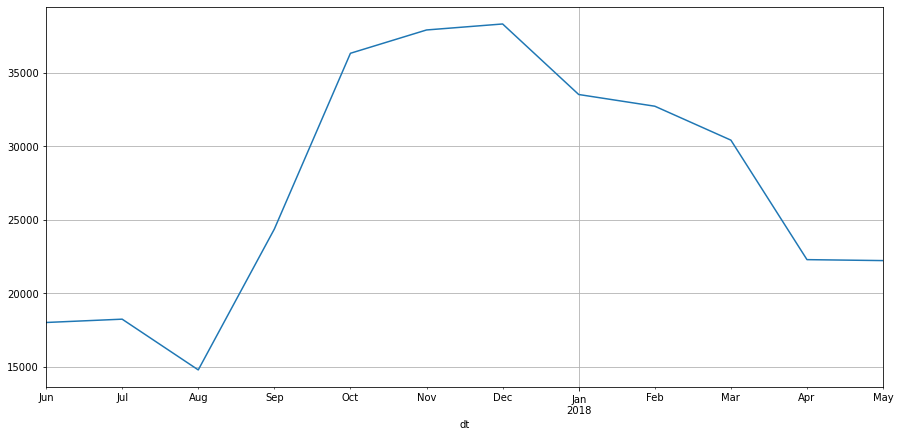

In [52]:
monthly_costs = costs.groupby('dt')['costs'].sum()
monthly_costs.plot(figsize=(15,7), grid=True)

В общем и целом совпадает с графиками посещаемости - с начала осени начинается театральный сезон, соответственно и рекламы, и людей больше.

Теперь наложим этот график с расходами на каждый источник рекламы. В первую очередь сгруппируем эти данные по истоничкам

In [53]:
every_source_costs = costs.pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
every_source_costs

source_id,1,2,3,4,5,9,10
dt,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


<AxesSubplot:xlabel='dt'>

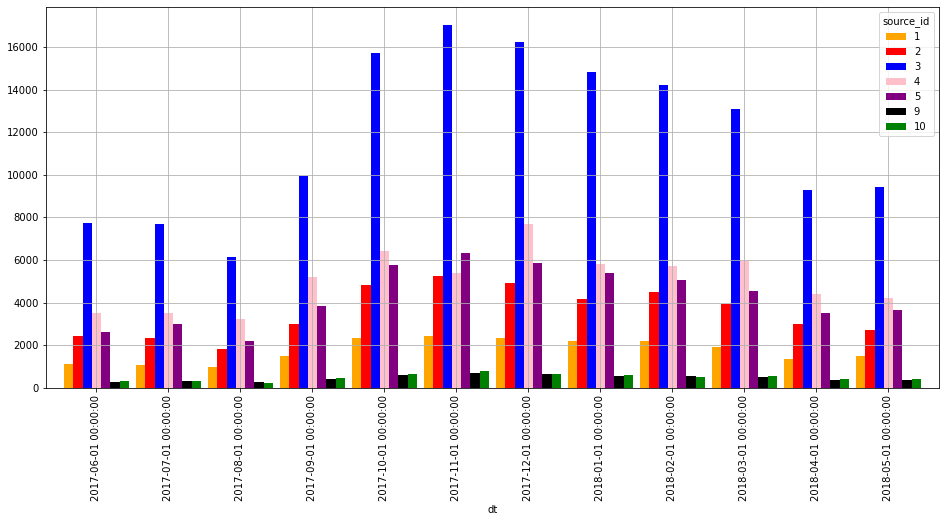

In [54]:
every_source_costs.plot.bar(width=0.9, figsize=(16, 7), color=['orange', 'red', 'blue', 'pink', 'purple', 'black', 'green'], grid=True)

На протяжении всего периода отчетливо видно, что примерно в два раза больше уходит денег на маркетинг через 3 канал, чем на его ближайшего преследователя. 

 Рассчитаем средний CAC на одного покупателя для всего проекта

In [55]:
mean_overall_cac = costs['costs'].sum() / cohort_sizes['n_buyers'].sum()
mean_overall_cac

9.011626098622786

Теперь для каждого источника трафика

In [56]:
source_costs = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
source_costs

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Это затраты на каждый источник трафика

<AxesSubplot:xlabel='[1, 2, 3, 4, 5, 9, 10]'>

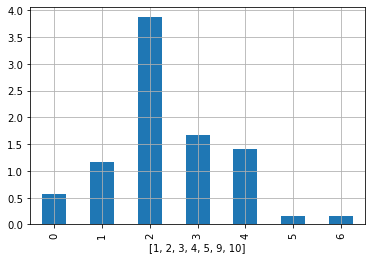

In [57]:
mean_source_cac = source_costs['costs'] / cohort_sizes['n_buyers'].sum()
mean_source_cac.plot(xlabel = source_costs['source_id'], kind='bar', grid=True)

В общем и целом на привлечение по 3 трафику приходится почти 4 условных единицы расходов, когда как на ближайшего преследователя, 4 трафик - чуть более 1.5 условных единицы расходов. 

Рассчитаем ROMI по когортам в разрезе источников. Начнем с выделения месяца в датафрейме расходов на маркетинг

In [58]:
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['month', 'source_id']).sum()
monthly_costs.reset_index(inplace=True)
monthly_costs

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


Объединим нужные столбцы с датафреймов по покупкам и визитам, чтобы обязательно был столбец с source_id

In [59]:
orders_upd = orders[['uid', 'first_buy_date', 'buy_ts', 'revenue']]
visits_upd = visits[['uid', 'source_id']]
df = orders_upd.merge(visits_upd, on='uid')
df.drop_duplicates(['uid', 'first_buy_date', 'buy_ts', 'revenue'], inplace=True)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           50415 non-null  int64         
 1   uid             50415 non-null  uint64        
 2   first_buy_date  50415 non-null  datetime64[ns]
 3   buy_ts          50415 non-null  datetime64[ns]
 4   revenue         50415 non-null  float64       
 5   source_id       50415 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), uint64(1)
memory usage: 2.3 MB


In [60]:
df['buy_ts'] = df['buy_ts'].astype('datetime64[M]')
df['first_buy_date'] = df['first_buy_date'].astype('datetime64[M]')
df

,index,uid,first_buy_date,buy_ts,revenue,source_id
0,0,10329302124590727494,2017-06-01,2017-06-01,17.00,1
1,1,11627257723692907447,2017-06-01,2017-06-01,0.55,2
2,2,17903680561304213844,2017-06-01,2017-06-01,0.37,2
3,3,16109239769442553005,2017-06-01,2017-06-01,0.55,2
4,4,14200605875248379450,2017-06-01,2017-06-01,0.37,3
...,...,...,...,...,...,...
50410,761798,12296626599487328624,2018-05-01,2018-05-01,4.64,4
50411,761800,11369640365507475976,2018-05-01,2018-05-01,5.80,10
50412,761801,1786462140797698849,2018-05-01,2018-05-01,0.30,3
50413,761802,3993697860786194247,2018-05-01,2018-05-01,3.67,4


Объединим данные с выручкой, расходами на маркетинг и кол-вом покупателей по месяцу покупки и источнику трафика

In [61]:
df1 = df.groupby(['buy_ts', 'source_id']).agg({'revenue': 'sum'}).reset_index()
df1.columns = ['month', 'source_id', 'revenue']
df1

,month,source_id,revenue
0,2017-06-01,1,1168.45
1,2017-06-01,2,1551.76
2,2017-06-01,3,2466.71
3,2017-06-01,4,2039.64
4,2017-06-01,5,1787.68
...,...,...,...
81,2018-05-01,4,4525.84
82,2018-05-01,5,2909.83
83,2018-05-01,9,347.45
84,2018-05-01,10,519.75


In [62]:
df2 = df1.merge(monthly_costs, on=['source_id', 'month'])
df2

,month,source_id,revenue,costs
0,2017-06-01,1,1168.45,1125.61
1,2017-06-01,2,1551.76,2427.38
2,2017-06-01,3,2466.71,7731.65
3,2017-06-01,4,2039.64,3514.80
4,2017-06-01,5,1787.68,2616.12
...,...,...,...,...
79,2018-05-01,3,3644.74,9411.42
80,2018-05-01,4,4525.84,4214.21
81,2018-05-01,5,2909.83,3669.56
82,2018-05-01,9,347.45,362.17


In [63]:
df3 = df.groupby(['buy_ts', 'source_id']).agg({'uid': 'count'}).reset_index()
df3.columns = ['month', 'source_id', 'n_buyers']
df3

,month,source_id,n_buyers
0,2017-06-01,1,267
1,2017-06-01,2,347
2,2017-06-01,3,621
3,2017-06-01,4,470
4,2017-06-01,5,432
...,...,...,...
81,2018-05-01,4,976
82,2018-05-01,5,761
83,2018-05-01,9,92
84,2018-05-01,10,145


In [64]:
df4 = df2.merge(df3, on=['month', 'source_id'])
df4

,month,source_id,revenue,costs,n_buyers
0,2017-06-01,1,1168.45,1125.61,267
1,2017-06-01,2,1551.76,2427.38,347
2,2017-06-01,3,2466.71,7731.65,621
3,2017-06-01,4,2039.64,3514.80,470
4,2017-06-01,5,1787.68,2616.12,432
...,...,...,...,...,...
79,2018-05-01,3,3644.74,9411.42,985
80,2018-05-01,4,4525.84,4214.21,976
81,2018-05-01,5,2909.83,3669.56,761
82,2018-05-01,9,347.45,362.17,92


Найдем LTV, CAC и ROMI

In [65]:
df4['ltv'] = df4['revenue'] / df4['n_buyers']
df4['cac'] = df4['costs'] / df4['n_buyers']
df4['romi'] = df4['ltv'] / df4['cac']
df4.sort_values(by=['source_id', 'month']).head(20)

,month,source_id,revenue,costs,n_buyers,ltv,cac,romi
0,2017-06-01,1,1168.45,1125.61,267,4.376217,4.215768,1.038059
7,2017-07-01,1,1985.01,1072.88,305,6.508230,3.517639,1.850170
14,2017-08-01,1,1251.84,951.81,248,5.047742,3.837944,1.315220
21,2017-09-01,1,3730.05,1502.01,512,7.285254,2.933613,2.483372
28,2017-10-01,1,3772.12,2315.75,670,5.630030,3.456343,1.628898
35,2017-11-01,1,4311.32,2445.16,749,5.756101,3.264566,1.763206
42,2017-12-01,1,4015.47,2341.20,852,4.712993,2.747887,1.715133
49,2018-01-01,1,3262.29,2186.18,620,5.261758,3.526097,1.492233
56,2018-02-01,1,3235.70,2204.48,669,4.836622,3.295187,1.467784
63,2018-03-01,1,4813.36,1893.09,690,6.975884,2.743609,2.542594


Посмотрим ROMI на каждый источник трафика

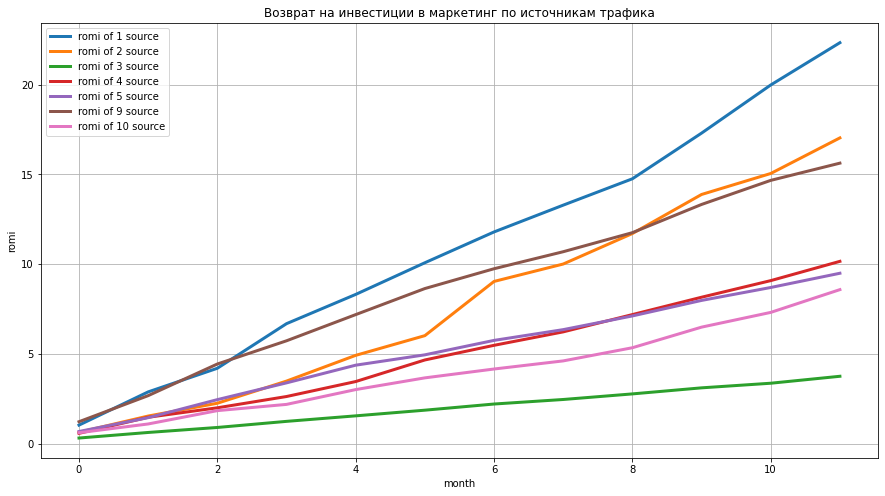

In [66]:
def romi(df, num):
    romi = df[df['source_id'] == num]['romi'].cumsum().reset_index()
    romi.columns = ['month', 'romi of {} source'.format(num)]
    romi['month'] = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May']
    #print('Возврат на инвестиции в маркетинг по {} источнику трафика составляет:'.format(num), '{}'.format(romi), sep='\n')
    romi['romi of {} source'.format(num)].plot(
        figsize=(15, 8), 
        grid=True, 
        xlabel = 'month', 
        ylabel = 'romi', 
        linewidth=3, 
        legend = True,
        title='Возврат на инвестиции в маркетинг по источникам трафика'
    )

source_id = [1, 2, 3, 4, 5, 9, 10]
for i in source_id:
    romi(df4, i)

Судя по графику, более выгодный ROMI за весь период имеют **1, 2 и 9 источники трафика**. Интересно, что 2 источник не сразу давал ощутимые результаты по окупаемости и только к концу временного отрезка обошел по суммарному ROMI 9 источник.
Учитывая, насколько мало выделяется расходов на 9, то, возможно, стоит увеличить там бюджет. Менее выгодным выходит 3 трафик, что неудивительно - на него уходит относительно большой бюджет расходов на маркетинг. 

Что касается когорт, то стоит обратить внимание на **сентябрьскую и июньские когорты**. Причем июньскую стоит разбавлять уведомлениями не только театров, но и концертов/квестов и других предложений из сайта Яндекс.Афиша ввиду особенностей театрального сезона, который начинается с осени.